In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from os.path import isfile
from os import listdir

128


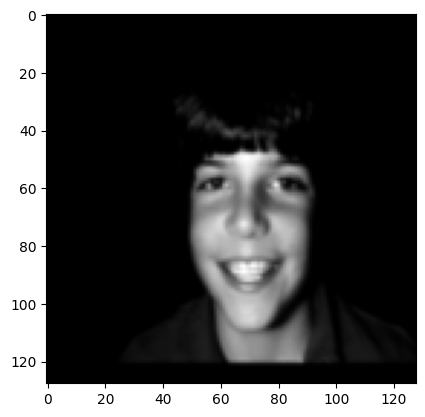

In [3]:
img = np.fromfile('./rawdata/1345',dtype=np.uint8)
l = int(np.sqrt(img.shape[0]))
print(l)
img = img.reshape((l,l))

plt.imshow(img,cmap=plt.cm.gray)


In [4]:
original_images = []

while len(original_images) < 500:

  image_num = randint(1223,5222)

  if not isfile('./rawdata/'+str(image_num)): continue

  temp = np.fromfile('./rawdata/'+str(image_num), dtype=np.uint8)
  l = int(np.sqrt(temp.shape[0]))
  temp = temp.reshape((l,l))
  original_images.append(temp)
  

  

In [5]:
min_rows = min_cols = sys.maxsize
max_rows = max_cols = 0

for (i, image) in enumerate(original_images):
  r, c = image.shape[0], image.shape[1]
  min_rows = min(min_rows, r)
  max_rows = max(max_rows, r)
  min_cols = min(min_cols, c)
  max_cols = max(max_cols, c)
  
print("\n==> Least common image size:", min_rows, "x", min_cols, "pixels")


==> Least common image size: 128 x 128 pixels


In [6]:
def recenter(image, min_rows, min_cols):
  r, c = image.shape
  top, bot, left, right = 0, r, 0, c 
  if r > min_rows:
    top = r - min_rows
  if c > min_cols:
    right = min_cols
  return image[top:bot, left:right]


In [7]:
recentered_images = []

for image in original_images:
  recentered_images.append(recenter(image,min_rows,min_cols))

In [8]:
mean_face  = np.mean(np.array(recentered_images),0)
recentered_images_mean0 = recentered_images - mean_face

In [9]:
m = len(recentered_images_mean0)
d  = min_rows * min_cols
X = np.reshape(recentered_images_mean0, (m,d))

In [10]:
U, Sigma, VT = np.linalg.svd(X,full_matrices=False)

In [11]:
print("X: ",X.shape)
print("U: ",U.shape)
print("Sigma: ",Sigma.shape)
print("V^T: ",VT.shape)

X:  (500, 16384)
U:  (500, 500)
Sigma:  (500,)
V^T:  (500, 16384)


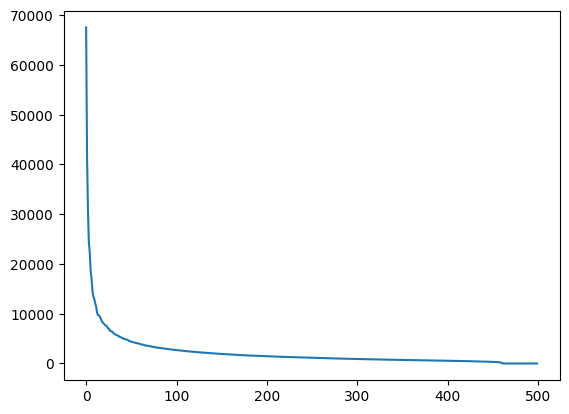

In [12]:
plt.plot(Sigma)

## Face reconstruction

(64, 64)


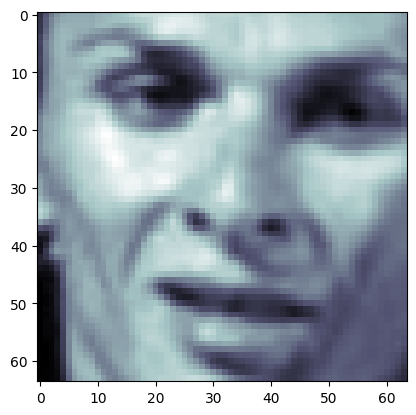

In [13]:
img = plt.imread('./lfw1000/Ana_Guevara_0005.pgm')
print(img.shape)
plt.imshow(img,cmap=plt.cm.bone)

In [14]:
# Step 1: obtain face images
# Step 2: Represent each image as a vector
faces = []
DIR = './lfw1000/'

for img in listdir(DIR):
  faces.append(plt.imread(DIR + img))
  
faces = np.reshape(np.array(faces), (len(faces),64**2))

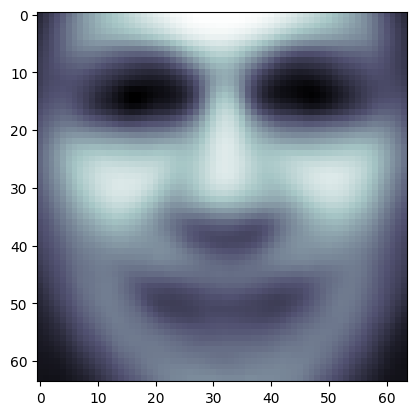

In [15]:
#Step 3: Compute the average 
mean_face = np.mean(np.array(faces),0)
plt.imshow(np.reshape(mean_face,(64,64)), cmap=plt.cm.bone)

In [16]:
# Step 4: subtract the mean face

faces_mean0 = np.array(faces) - mean_face

In [17]:
# Step 5: Compute the covariance matrix
A = (np.array(faces) - mean_face).T
C = A.T @ A

In [19]:
# Step 6 Compute the eigenvectors

eigvals, V = np.linalg.eig(C)
print(eigvals.shape)

(1071,)


In [20]:
sorted_mu = np.argsort(-1*eigvals)

u = np.array([])

for i in sorted_mu[:400]:
  ui = A @ V[:, i].T 
  
  if len(u) == 0:
    u = ui
  else:
    u = np.vstack((u,ui))
u = u.T

In [21]:
eigenfaces = np.diag(eigvals[:400]) @ u.T

## Reconstruccion

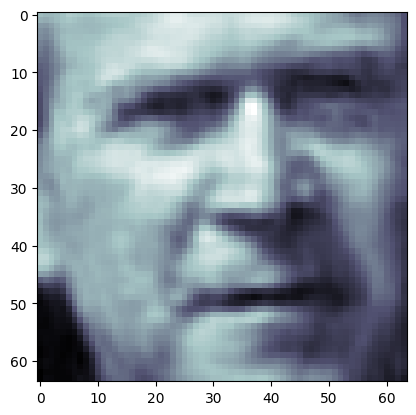

In [22]:
test1 = plt.imread('./lfw1000/George_W_Bush_0274.pgm')
val, res, rank, sing = np.linalg.lstsq(u, np.reshape(test1,(64*64)), rcond= None)
num_eigenfaces = 250
reconstruccion = u[:,:num_eigenfaces] @ val[:num_eigenfaces]

plt.imshow(np.reshape(reconstruccion,(64,64)),cmap=plt.cm.bone)

In [23]:
import cv2

joaquin = plt.imread('IMG_20201027_153546.jpg')
joaquin = joaquin[1400:3450,700:2750,:]
joaquin = cv2.cvtColor(joaquin, cv2.COLOR_RGB2GRAY)

layer = joaquin.copy()
gp = [layer]

for j in range(5):
  layer = cv2.pyrDown(layer)
  gp.append(layer)


joaquin_pequenio = gp[5]
joaquin_pequenio = joaquin_pequenio[:-1,:-1]

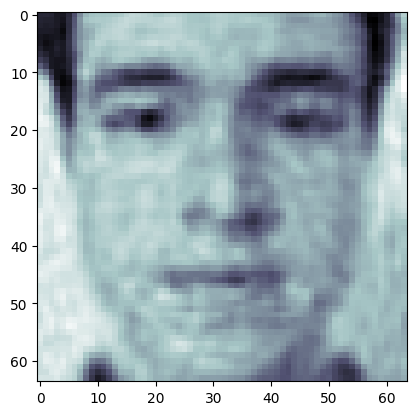

In [27]:
val, res, rank, sing = np.linalg.lstsq(u, np.reshape(joaquin_pequenio,(64*64)), rcond= None)
num_eigenfaces = 400
reconstruccion = u[:,:num_eigenfaces] @ val[:num_eigenfaces]

plt.imshow(np.reshape(reconstruccion,(64,64)),cmap=plt.cm.bone)

## Face Morphing

In [43]:
target1 = plt.imread('./lfw1000/David_Beckham_0030.pgm')
target2 = plt.imread('./lfw1000/Elton_John_0006.pgm')

def face_morphing(target1: np.ndarray, target2: np.ndarray, save_path: str):

  solution1 = np.linalg.lstsq(u, target1.flatten(), rcond=None)
  solution2 = np.linalg.lstsq(u, target2.flatten(), rcond=None)

  cont = 0

  for k in range(700,10,-5):
    reconstruction = u[:,:k] @ solution1[0][:k]
    reconstruction = np.reshape(reconstruction,(64,64))
    
    plt.imsave(f'./{save_path}/'+str(cont)+'-target1-'+str(k)+'-eigenfaces.png',reconstruction)
    cont += 1
    
  for k in range(10,700,5):
    reconstruction = u[:,:k] @ solution2[0][:k]
    reconstruction = np.reshape(reconstruction,(64,64))
    
    plt.imsave(f'./{save_path}/'+str(cont)+'-target2-'+str(k)+'-eigenfaces.png',reconstruction)
    cont +=1


In [ ]:
face_morphing(target1, target2, "morphing2")

In [48]:
import glob
from PIL import Image

def make_gif(frame_folder, filename):
  frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.PNG")]
  frame_one = frames[0]
  frame_one.save(f"{filename}.gif",format="GIF", append_images=frames,save_all=True, duration=500,loop=0)
  

In [49]:
make_gif("./morphing_joaquin","joaquin_beckham")

In [44]:
face_morphing(joaquin_pequenio,target1,'morphing_joaquin')